In [174]:
import math

import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl

from torchvision.transforms import ToTensor

import PIL
import tqdm

In [22]:
class LinearSinus0(nn.Linear):
    def forward(self, x):
        x = super().forward(x)
        return x.sin()

# To do: override weight initialization
# >> W ∼ U(−sqrt(6/n), sqrt(6/n))
#
# Special initialization for first layer:
# >   Finally, we propose to initialize the first layer of the sine network with weights so that the
# > sine function sin(ω0 · Wx + b) spans multiple periods over [−1, 1]. We found ω0 = 30 to work
# > well for all the applications in this work. The proposed initialization scheme yielded fast and robust
# > convergence using the ADAM optimizer for all experiments in this work.
#
# Both notes from end of sec 3
#
# Supp 1.5 discusses
#
# >   1.5 About ω0
# > As discussed above, we aim to provide each sine nonlinearity with activations that are standard
# > normal distributed, except in the case of the first layer, where we introduced a factor ω0 that increased
# > the spatial frequency of the first layer to better match the frequency spectrum of the signal. However,
# > we found that the training of SIREN can be accelerated by leveraging a factor ω0 in all layers of the
# > SIREN, by factorizing the weight matrix W as W = Wˆ ∗ ω0, choosing Wˆ ∼ U(−q c ω20n, q c ω20n).
# > This keeps the distribution of activations constant, but boosts gradients to the weight matrix Wˆ by
# > the factor ω0 while leaving gradients w.r.t. the input of the sine neuron unchanged.

In [356]:
class LinearSinus(nn.Module):
    def __init__(self, in_features, out_features, omega=30, upscale_init=False, bias=True):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        self.omega = omega
        self.upscale_init = upscale_init # i.e. "is this the first layer?"
        self._init_weights()
    def forward(self, x):
        x = (self.omega*x).float()
        x = self.linear(x)
        x = x.sin()
        return x
    def _init_weights(self):
        scale_factor = self.omega
        if self.upscale_init:
            scale_factor = 1
        with torch.no_grad():
            W = self.linear.weight
            n = W.shape[-1] # in_features
            k = (math.sqrt(6/n) / self.omega ) / scale_factor
            W.uniform_(-k,k)
    
class SinusBlock(nn.Module):
    def __init__(self, 
                 in_features, 
                 out_features, 
                 hidden_features, 
                 n_layers=3):
        super().__init__()
        layers = [LinearSinus(in_features, hidden_features, upscale_init=True)]
        for _ in range(n_layers-1):
            layers.append(LinearSinus(hidden_features, hidden_features))
        layers.append(LinearSinus(hidden_features, out_features))
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.block(x)

In [357]:
# sanity test

foo = LinearSinus(3, 1)

x = torch.rand(2,3)
x, foo(x)

bar = SinusBlock(2, 3, 215, 3)
bar, bar(torch.rand(5,2))

(SinusBlock(
   (block): Sequential(
     (0): LinearSinus(
       (linear): Linear(in_features=2, out_features=215, bias=True)
     )
     (1): LinearSinus(
       (linear): Linear(in_features=215, out_features=215, bias=True)
     )
     (2): LinearSinus(
       (linear): Linear(in_features=215, out_features=215, bias=True)
     )
     (3): LinearSinus(
       (linear): Linear(in_features=215, out_features=3, bias=True)
     )
   )
 ),
 tensor([[-0.0642,  0.0637, -0.0041],
         [-0.0642,  0.0637, -0.0041],
         [-0.0641,  0.0637, -0.0041],
         [-0.0642,  0.0637, -0.0040],
         [-0.0642,  0.0637, -0.0041]], grad_fn=<SinBackward>))

# Image Fitting

In [ ]:
# 1. sample batch of locations
# 2. get pixel values at locations
# 3. fit that shit

# let's start small and b&w

##############

# addl experiments
# - image upsampling via predicting interpolated pixel values
# - investigate relationship between image size and network capacity
# - use SIRENs to model convolutional filters

In [75]:
im_path = '../data/google-photos-export/uncompressed/takeout-20210901T023707Z-001/Takeout/Google Photos/lithophane candidates/20210313_133327.jpg'
im = PIL.Image.open(im_path)

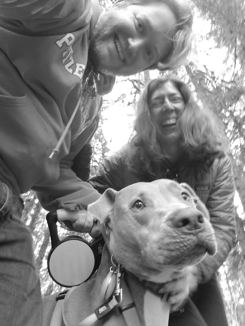

In [89]:
##im.size # (3264, 2448)
im2 = im.resize((326,245)).convert('L').rotate(-90, expand=True)
im2

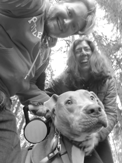

In [98]:
im3 = im2.resize((122, 163))
im3

In [193]:
t_im3 = ToTensor()(im3).squeeze()

# sample some coords
batch_size = 16
row_coords = torch.randint(t_im3.shape[0], size=(batch_size, 1)) # takes a device arg
col_coords = torch.randint(t_im3.shape[1], size=(batch_size, 1)) # takes a device arg

batch = t_im3[row_coords,col_coords]
batch.shape

def emit_pixel_batch(im, batch_size):
    # this would prob look way cleaner with einops...
    row_coords = torch.randint(im.shape[0], size=(batch_size, 1)) # takes a device arg
    col_coords = torch.randint(im.shape[1], size=(batch_size, 1)) # takes a device arg

    pv = im[row_coords,col_coords]
    pc = torch.cat([row_coords, col_coords], dim=1) 
    return {'pixel_values':pv, 'pixel_coords':pc}

emit_pixel_batch(t_im3, batch_size)

{'pixel_values': tensor([[0.3059],
         [0.5529],
         [0.4784],
         [0.9373],
         [0.5725],
         [0.2275],
         [0.6471],
         [0.8392],
         [0.6431],
         [0.7882],
         [0.2667],
         [0.4706],
         [0.3059],
         [0.7098],
         [0.7059],
         [0.7804]]),
 'pixel_coords': tensor([[ 97,   9],
         [ 90, 111],
         [142,  41],
         [  6,  74],
         [162,  65],
         [ 78,  95],
         [ 31,  34],
         [139,  53],
         [133,  37],
         [103,  53],
         [146,  67],
         [ 70, 101],
         [ 80,  12],
         [146,  58],
         [ 18, 118],
         [ 79,  54]])}

In [302]:
(idx /torch.tensor(t_im3.shape).to(DEVICE)).shape

torch.Size([19886, 2])

In [358]:
DEVICE = 'cuda'

def make_idx(im_in):
    idx = []
    x,y = im_in.shape
    for i in range(x):
        for j in range(y):
            idx.append((i,j))
    idx = torch.tensor(idx, device=DEVICE)
    return idx

def normalize_idx(idx, row_cnt=t_im3.shape[0], col_cnt=t_im3.shape[1]):
    #idx = idx/idx.max(dim=0).values # normalize to [0,1]
    idx = idx /torch.tensor([row_cnt-1, col_cnt-1], device=DEVICE)
    #idx = idx*2 -1 # normalize to [-1. 1]
    idx = (idx - .5) / .5
    return idx

#def generate_img(model, im_in):
def generate_img(model, idx0, idx_normed):
    #idx = make_idx(im_in)
    with torch.no_grad():
        #y_out = model(idx)
        y_out = model(idx_normed)
#    im_out=torch.sparse_coo_tensor(idx.T, y_out.squeeze(),  t_im3.shape, device=DEVICE)
    im_out=torch.sparse_coo_tensor(
        indices=idx0.T, 
        values=y_out.squeeze(),  
        size=tuple(idx0.max(dim=0).values+1), #idx0.shape, 
        device=torch.device('cuda') #device=DEVICE
    )
    return im_out.to_dense()

In [351]:
#idx.shape
#idx = idx/idx.max(dim=0).values

idx = make_idx(t_im3)
(idx.min(), idx.max()),\
(normalize_idx(idx).min(), normalize_idx(idx).max())

((tensor(0, device='cuda:0'), tensor(162, device='cuda:0')),
 (tensor(-1., device='cuda:0'), tensor(1., device='cuda:0')))

In [326]:
idx.max(dim=0).values+1

tensor([163, 122], device='cuda:0')

In [295]:
2048*64

131072

  0%|                                                                                        | 0/50000 [00:00<?, ?it/s]

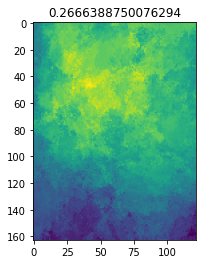

  0%|▏                                                                              | 98/50000 [00:01<11:05, 75.03it/s]

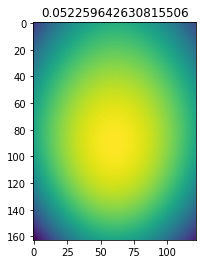

  0%|▎                                                                             | 196/50000 [00:02<11:07, 74.62it/s]

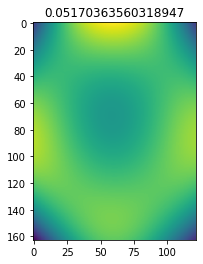

  1%|▍                                                                             | 295/50000 [00:04<11:01, 75.09it/s]

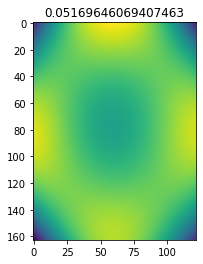

  1%|▌                                                                             | 393/50000 [00:05<11:12, 73.80it/s]

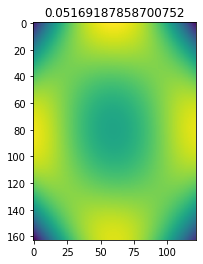

  1%|▊                                                                             | 498/50000 [00:07<11:07, 74.16it/s]

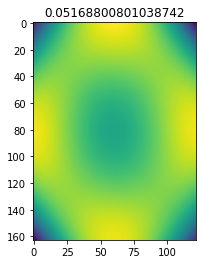

  1%|▉                                                                             | 594/50000 [00:08<11:08, 73.95it/s]

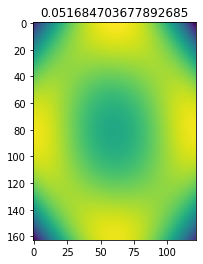

  1%|█                                                                             | 699/50000 [00:10<10:58, 74.90it/s]

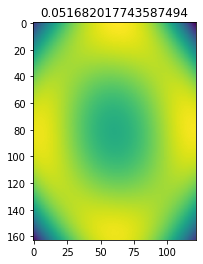

  2%|█▏                                                                            | 795/50000 [00:11<11:08, 73.61it/s]

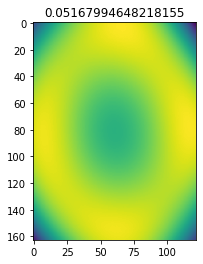

  2%|█▍                                                                            | 900/50000 [00:12<11:06, 73.62it/s]

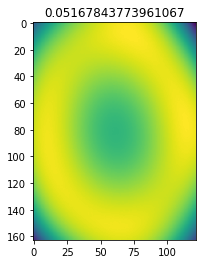

  2%|█▌                                                                            | 997/50000 [00:14<11:19, 72.13it/s]

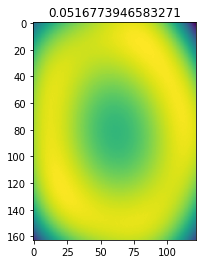

  2%|█▋                                                                           | 1095/50000 [00:15<10:54, 74.72it/s]

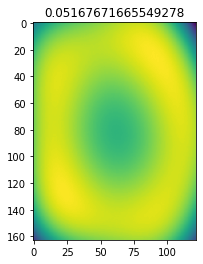

  2%|█▊                                                                           | 1199/50000 [00:17<11:08, 73.04it/s]

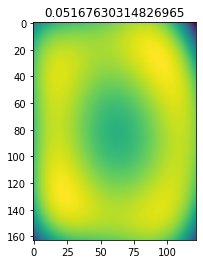

  3%|█▉                                                                           | 1296/50000 [00:18<11:05, 73.16it/s]

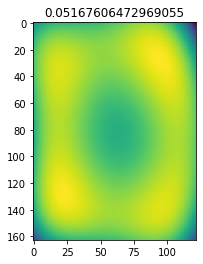

  3%|██▏                                                                          | 1393/50000 [00:19<11:06, 72.91it/s]

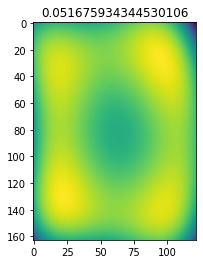

  3%|██▎                                                                          | 1499/50000 [00:21<11:05, 72.91it/s]

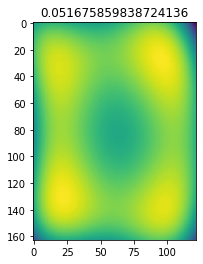

  3%|██▍                                                                          | 1596/50000 [00:22<11:01, 73.14it/s]

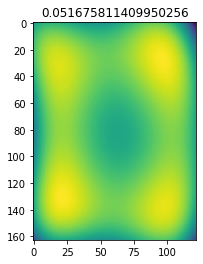

  3%|██▌                                                                          | 1693/50000 [00:24<10:53, 73.87it/s]

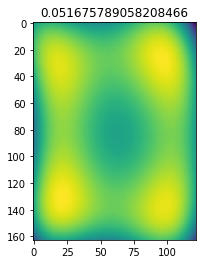

  4%|██▊                                                                          | 1797/50000 [00:25<10:57, 73.29it/s]

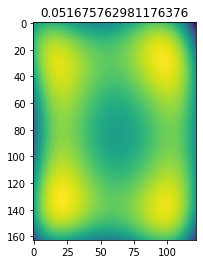

  4%|██▉                                                                          | 1894/50000 [00:27<10:59, 72.90it/s]

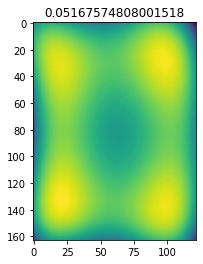

  4%|███                                                                          | 1998/50000 [00:28<10:52, 73.52it/s]

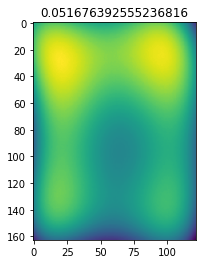

  4%|███▏                                                                         | 2096/50000 [00:30<10:57, 72.87it/s]

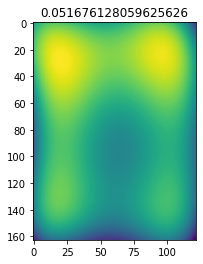

  4%|███▍                                                                         | 2193/50000 [00:31<10:52, 73.21it/s]

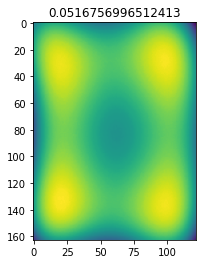

  5%|███▌                                                                         | 2297/50000 [00:33<10:58, 72.43it/s]

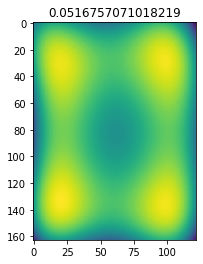

  5%|███▋                                                                         | 2394/50000 [00:34<10:47, 73.56it/s]

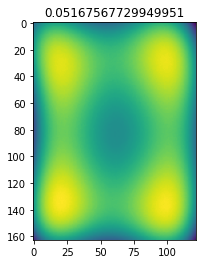

  5%|███▋                                                                         | 2426/50000 [00:35<11:28, 69.07it/s]


KeyboardInterrupt: 

In [361]:
n_channels = 1
#model = SinusBlock(2, n_channels, 215, 3)
model = SinusBlock(2, n_channels, 256, 5)
model.train()
model.to(DEVICE)

#opt = torch.optim.Adam(model.parameters(), lr=1e-4)
opt = torch.optim.Adam(model.parameters(), lr=1e-5)
opt.zero_grad()

loss_func = nn.MSELoss()
#loss_func = nn.L1Loss()

log_every = 100
n_steps = 50000
#batch_size = 512 #16
#batch_size = 2048
#batch_size = 2048*64

t_im3 = t_im3.to(DEVICE)
idx0 = make_idx(t_im3)#.to(DEVICE)
v = t_im3[idx0[:,0], idx0[:,1]]#.to(DEVICE)
idx_normed = normalize_idx(idx0)



losses = []
for i in tqdm.trange(n_steps):
    #batch = emit_pixel_batch(t_im3, batch_size)
    batch={'pixel_coords':idx_normed,
           'pixel_values':v
          }
     
    #idx = batch['pixel_coords'].to(DEVICE)
    #idx = idx/idx.max(dim=0).values # normalize to [0,1]
    #idx = idx*2 -1 # normalize to [-1. 1]
    
    #y_out = model(idx).sigmoid()
    y_out = model(idx_normed)
    #y_out = model(idx_normed).sigmoid()
    y_true = batch['pixel_values']
    #loss = # oooooh shit. this is why this works. 
    # the loss is relative to the entire image. thinking in terms
    # of the data, I would normally calculate the loss relative to 
    # the specific predicted values... but the network actually 
    # parameterizes the whole image. So it makes sense to evaluate the 
    # whole image for the loss.
    # ....fuck it let's just do mse for now.
    loss = loss_func(y_out, y_true)
    loss.backward()
    opt.step()
    losses.append(loss.detach().item())
    opt.zero_grad()
    
    with torch.no_grad():
        if (i % log_every == 0):
            #im_i = generate_img(model, t_im3).to('cpu')
            im_i = generate_img(model, idx0, idx_normed).to('cpu')
            plt.imshow(im_i)
            plt.title(losses[-1])
            plt.show()
            
plotting_burnin = 150
plt.plot(losses[plotting_burnin:])
plt.show()

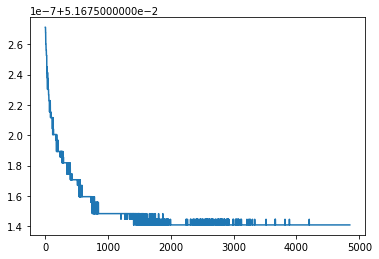

In [342]:
plotting_burnin = 150
plt.plot(losses[plotting_burnin:])

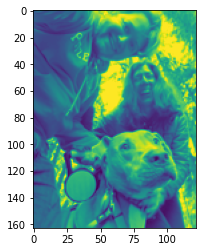

In [347]:
# Double check that the reconstruction process here even works...

idx0 = make_idx(t_im3)
v = t_im3[idx0[:,0], idx0[:,1]]

im_recons=torch.sparse_coo_tensor(
    indices=idx0.T, 
    values=v,
    size=tuple(idx0.max(dim=0).values+1), #idx0.shape, 
    device=torch.device('cuda') #device=DEVICE
)

plt.imshow(im_recons.to_dense().cpu())
plt.show()
# ok, at least I'm not totally crazy

In [283]:
# wrong loss LPIPS or somethign like that?
# Oh wait, I think I need to add a softmax or logit at the end here... 
# yeah, logit I think.

tensor([[0.0000, 0.0000],
        [0.0000, 0.0083],
        [0.0000, 0.0165],
        ...,
        [1.0000, 0.9835],
        [1.0000, 0.9917],
        [1.0000, 1.0000]], device='cuda:0')

In [269]:
v.shape

torch.Size([19886])

In [232]:
with torch.no_grad():
    y_out = model(idx)

In [270]:
idx.shape

torch.Size([19886, 2])

In [236]:
 t_im3.unsqueeze(0).shape

torch.Size([1, 163, 122])

In [238]:
idx.shape

torch.Size([19886, 2])

In [244]:
im_out=torch.sparse_coo_tensor(idx.T, y_out.squeeze(),  t_im3.shape)

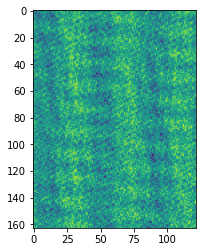

In [245]:
plt.imshow(im_out.to_dense())# hmm....

In [240]:
y_out.shape

torch.Size([19886, 1])

# Lightning variant

In [ ]:
class LinearSinus(nn.Module):
    def __init__(self, in_features, out_features, omega=30, upscale_init=False, bias=True):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        self.omega = omega
        self.upscale_init = upscale_init # i.e. "is this the first layer?"
        self._init_weights()
    def forward(self, x):
        x = (self.omega*x).float()
        x = self.linear(x)
        x = x.sin()
        return x
    def _init_weights(self):
        scale_factor = self.omega
        if self.upscale_init:
            scale_factor = 1
        with torch.no_grad():
            W = self.linear.weight
            n = W.shape[-1] # in_features
            k = (math.sqrt(6/n) / self.omega ) / scale_factor
            W.uniform_(-k,k)

In [375]:
# Use this pattern for defining a custom activation function
# https://discuss.pytorch.org/t/relu-with-leaky-derivative/32818/5
# uh... nevermind

In [576]:
class LinearSinus(nn.Module):
    def __init__(self, in_features, out_features, omega=30, is_first_layer=False):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.omega=float(omega)
        self.is_first_layer = is_first_layer
        
        self.linear = nn.Linear(in_features, out_features)
        self._init_weights()
    
    def forward(self, x):
        #print(self.linear.weight)
        #x *= self.omega
        x = x*self.omega
        x = self.linear(x)
        #x = self.sin(x)
        x = x.sin()
        return x
    
    def _init_weights(self):
        with torch.no_grad():
            k = math.sqrt(6/self.in_features)
            self._k0 = k
            if not self.is_first_layer:
                #k /= self.omega
                k = k / self.omega
            self._k1 = k
            #print(self.linear.weight.shape)
            #print(self.linear.weight)
            self.linear.weight.uniform_(-k,k)
            #print(self.linear.weight)
        #print(self.linear.weight)


def make_idx(im_in):
    idx = []
    x,y = im_in.shape
    for i in range(x):
        for j in range(y):
            idx.append((i,j))
    idx = torch.tensor(idx, device=DEVICE)
    return idx

        
class SirenImageLearner(pl.LightningModule):
    def __init__(self, 
                 in_features=2,
                 out_features=1,
                 dim_hidden=256,
                 n_hidden=5,
                 lr=1e-4):
        super().__init__()
        
        # getting an error complaining that self.hparams isn't a dict...
        #self.save_hyperparameters() # looks like this doesn't help
        
        #self.target_image = target_image
        self.in_features = in_features
        self.out_features = out_features
        self.dim_hidden = dim_hidden
        self.n_hidden = n_hidden
        self.lr = lr
        
        layers = [
            LinearSinus(
                in_features=in_features,
                out_features=dim_hidden,
                is_first_layer=True
            )]
        for _ in range(n_hidden):
            layers.append(LinearSinus(in_features=dim_hidden, out_features=dim_hidden))
        layers.append(LinearSinus(in_features=dim_hidden, out_features=out_features))
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.block(x)
    
    def training_step(self, batch, batch_idx):
        tb = self.trainer.logger.experiment

        y_true = batch['pixel_values'].clone().detach().requires_grad_(True)
        coords_rescaled = batch['coords_rescaled'].clone().detach().requires_grad_(True)
        
        y_pred = self.forward(coords_rescaled).squeeze()
        loss = F.mse_loss(y_pred, y_true)
        
        #tb.add_histogram('loss_grad', loss.grad, batch_idx) # uh....
        self.log("train_loss", loss)
        
        # fuck it...
        idx0=batch['coords']
        im_recons=torch.sparse_coo_tensor(
            indices=idx0.T, 
            values=y_true,
            size=tuple(idx0.max(dim=0).values+1),
            device=torch.device(DEVICE) #device=DEVICE
        ).to_dense().unsqueeze(0)
        
        tb.add_image('source',im_recons, batch_idx)
        
        im_pred = torch.sparse_coo_tensor(
            indices=idx0.T, 
            values=y_pred,
            size=tuple(idx0.max(dim=0).values+1),
            device=torch.device(DEVICE) #device=DEVICE
        ).to_dense().unsqueeze(0)
        
        #tb.add_image('pred', im_pred, batch_idx)
        #tb.add_image('pred', im_pred)
        tb.add_image('pred', im_pred, self.global_step)
        
        # For debugging the nan loss
        self.log('y_pred.shape', torch.tensor(y_pred.shape), batch_idx)
        self.log('y_true.shape', torch.tensor(y_true.shape), batch_idx)
        
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


In [574]:
#https://pytorch-lightning.readthedocs.io/en/latest/guides/data.html
class SirenImageDataWrapper(pl.LightningDataModule):
    def __init__(self, target_image):
        super().__init__()
        self.target_image = target_image
    
    def prepare_data(self):
        self._scale = torch.tensor(self.target_image.shape, device=DEVICE) - 1
        coords = make_idx(self.target_image)
        self._coords = coords
        self._coords_rescaled = self._rescale_coords(coords)
        
        x = self._coords[:,0]
        y = self._coords[:,1]
        batch= {
            'pixel_values': self.target_image[x, y],
            'coords_rescaled': self._coords_rescaled,
            'coords':self._coords,
            'tgt_img': self.target_image
        }
        self._dataset = batch
        
        class Loader(torch.utils.data.IterableDataset):
            def __iter__(_self):
                yield self._dataset
                
        self._Loader = Loader()
        
    def _rescale_coords(self, coords):
        """
        Implicit representation takes coordinates as input and outputs pixel value at that position of the image.
        To stabilize network training, we need to rescale these coordinates from [0,im_size]**2 to [-1,1]**2
        """
        with torch.no_grad(): # probably doesn't make a difference...
            b = (coords / self._scale)
            b = (b-.5)/.5
        return b
    
    def train_dataloader(self):
        return self._Loader

In [529]:
pl_wrapper = SirenImageDataWrapper(target_image=t_im3)
#pl_wrapper.setup()
pl_wrapper.prepare_data()
for batch in pl_wrapper.train_dataloader():
    break
(batch['pixel_values'].shape, batch['pixel_values'].min(), batch['pixel_values'].max()),\
(batch['coords_rescaled'].shape, batch['coords_rescaled'].min(), batch['coords_rescaled'].max())

((torch.Size([19886]),
  tensor(0.0549, device='cuda:0'),
  tensor(1., device='cuda:0')),
 (torch.Size([19886, 2]),
  tensor(-1., device='cuda:0'),
  tensor(1., device='cuda:0')))

In [578]:
model = SirenImageLearner()
dm = SirenImageDataWrapper(target_image=t_im3)
trainer = pl.Trainer(
    gpus=-1,
    max_steps=1000,
    log_every_n_steps=50
)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | block | Sequential | 329 K 
-------------------------------------
329 K     Trainable params
0         Non-trainable params
329 K     Total params
1.320     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

In [550]:
pl_wrapper = SirenImageDataWrapper(target_image=t_im3)
pl_wrapper.prepare_data()
for batch in pl_wrapper.train_dataloader():
    break
    
model.to(DEVICE)
coords_rescaled = batch['coords_rescaled'].to(DEVICE)
y_pred = model.forward(coords_rescaled).squeeze() # why was the model on the cpu? weird.
y_true = batch['pixel_values'].to(DEVICE)
loss = F.mse_loss(y_pred, y_true)

In [551]:
loss

tensor(0.6100, device='cuda:0', grad_fn=<MseLossBackward>)

In [582]:
loss.grad # not a leaf tensor... interesting.

C:\Users\shagg\AppData\Local\Temp/ipykernel_9740/1575125927.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  loss.grad # not a leaf tensor... interesting.


# Upsampling

In [627]:
# let's see how we do reproducing the original image
t_im1 = ToTensor()(im.convert('L').rotate(-90, expand=True)).squeeze()
im1_coords = make_idx(t_im1)

scale = torch.tensor(t_im1.shape, device=DEVICE) - 1
with torch.no_grad(): # probably doesn't make a difference...
    b = (im1_coords / scale)
    b = (b-.5)/.5
im1_coords_rescaled = b

model.to('cuda')
y_pred = model(im1_coords_rescaled).squeeze()

im_recons_upsampled=torch.sparse_coo_tensor(
        indices=im1_coords.T, 
        values=y_pred,
        size=t_im1.shape, #tuple(idx0.max(dim=0).values+1),
        device=torch.device(DEVICE) #device=DEVICE
    ).to_dense().unsqueeze(0)

RuntimeError: CUDA out of memory. Tried to allocate 7.62 GiB (GPU 0; 24.00 GiB total capacity; 17.50 GiB already allocated; 4.41 GiB free; 17.57 GiB reserved in total by PyTorch)

In [626]:
torch.cuda.empty_cache() # prob need to restart the kernel?
# guessing this happened from me repeatedly moving the model onto the kernel?

In [621]:
t_im1.shape

torch.Size([3, 2448, 3264])

In [ ]:
coords_rescaled = batch['coords_rescaled'].clone().detach().requires_grad_(True)
        
        y_pred = self.forward(coords_rescaled).squeeze()
        loss = F.mse_loss(y_pred, y_true)
        
        #tb.add_histogram('loss_grad', loss.grad, batch_idx) # uh....
        self.log("train_loss", loss)
        
        # fuck it...
        idx0=batch['coords']
        im_recons=torch.sparse_coo_tensor(
            indices=idx0.T, 
            values=y_true,
            size=tuple(idx0.max(dim=0).values+1),
            device=torch.device(DEVICE) #device=DEVICE
        ).to_dense().unsqueeze(0)

In [ ]:
 def prepare_data(self):
        self._scale = torch.tensor(self.target_image.shape, device=DEVICE) - 1
        coords = make_idx(self.target_image)
        self._coords = coords
        self._coords_rescaled = self._rescale_coords(coords)
        
        x = self._coords[:,0]
        y = self._coords[:,1]
        batch= {
            'pixel_values': self.target_image[x, y],
            'coords_rescaled': self._coords_rescaled,
            'coords':self._coords,
            'tgt_img': self.target_image
        }
        self._dataset = batch
        
        class Loader(torch.utils.data.IterableDataset):
            def __iter__(_self):
                yield self._dataset
                
        self._Loader = Loader()
        
    def _rescale_coords(self, coords):
        """
        Implicit representation takes coordinates as input and outputs pixel value at that position of the image.
        To stabilize network training, we need to rescale these coordinates from [0,im_size]**2 to [-1,1]**2
        """
        with torch.no_grad(): # probably doesn't make a difference...
            b = (coords / self._scale)
            b = (b-.5)/.5
        return b

# Implicit Convolutional Operators

Let's see what happens if we try to model convolutional filters with SIRENs.

Start with a sanity check to make sure i'm using `torch.unfold` to extract image patches correctly first.

In [583]:
t_im3.shape

torch.Size([163, 122])

In [614]:
#164/2/2/2/2/2
#163/32 # 5 patches full stride
#122/32 # 3 patches, might benefit from some striding.
patches = F.unfold(t_im3.unsqueeze(0).unsqueeze(0), 
                   kernel_size=(32,32),
                   stride=(32,32)
                  )
len(patches), patches[0].shape

(1, torch.Size([1024, 15]))

In [598]:
for i in range(patches.shape[-1]):
    patch = patches[:,i]
    break

In [599]:
import einops as eo

In [615]:
patches.shape
patches = eo.rearrange(patches, 'c (h w) k -> c h w k', h=32)#.shape

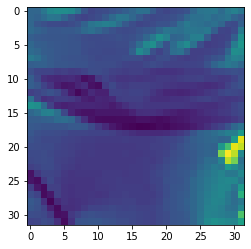

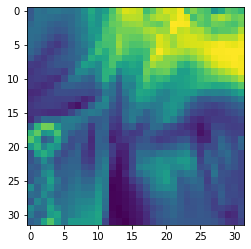

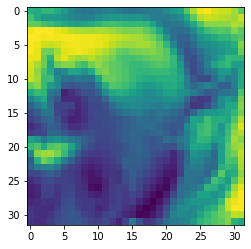

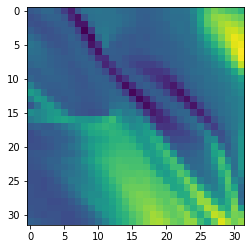

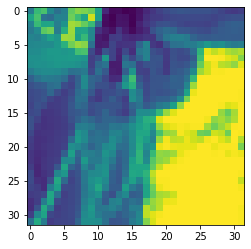

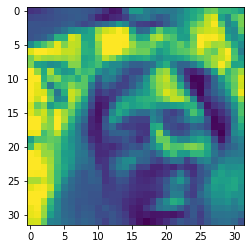

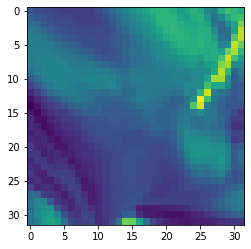

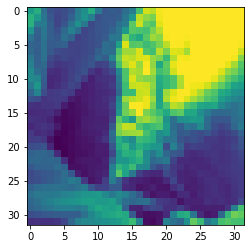

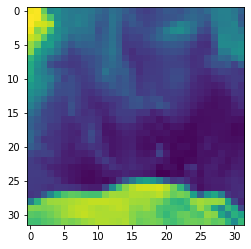

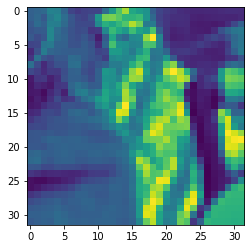

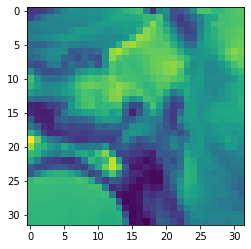

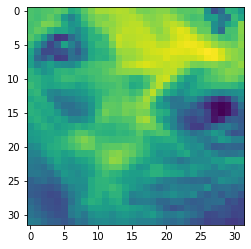

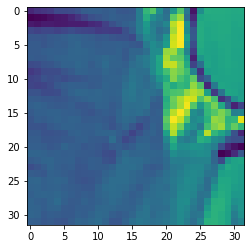

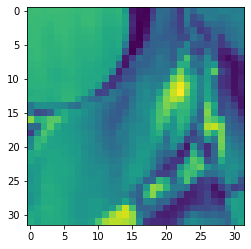

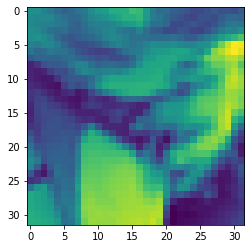

In [619]:
for i in range(patches.shape[-1]):
    patch = patches[:,:,:,i]
    plt.imshow(patch.clone().squeeze().cpu().numpy())
    plt.show()
# conversely, I could also just request the patches I want from the fitted SIREN
# feels like this has potential for memory savings?

In [617]:
patch.shape

torch.Size([1, 32, 32])